In [7]:
from numpy import *
from PIL import Image
import pickle
from pylab import *
import os
from scipy.misc import *
from matplotlib.pyplot import *

In [2]:
import sift
import dsift
dsift = reload(dsift)
import imtools
imtools = reload(imtools)

In [3]:
def compute_feature(im):
    """ Returns a feature vector for an
    ocr image patch. """
    
    # resize and remove border
    norm_im = imresize(im, (30, 30))
    norm_im = norm_im[3:-3, 3:-3]
    
    return norm_im.flatten()

In [4]:
def load_ocr_data(path):
    """ Return labels and ocr features for all images in path. """
    
    # create list of all files ending in .jpg
    imlist = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]
    
    labels = [int(imfile.split('/')[-1][0]) for imfile in imlist]
    features = []
    for imname in imlist:
        im = array(Image.open(imname).convert('L'))
        features.append(compute_feature(im))
    return array(features), labels

In [5]:
from svmutil import *

In [24]:
features, labels = load_ocr_data('sudoku_images/ocr_data/training/')
test_features, test_labels = load_ocr_data('sudoku_images/ocr_data/testing/')

In [ ]:
features = map(list, features)
test_features = map(list, test_features)

In [9]:
prob = svm_problem(labels, features)
param = svm_parameter('-t 0')
m = svm_train(prob, param)

In [10]:
res = svm_predict(labels, features, m)

Accuracy = 100% (1409/1409) (classification)


In [11]:
res = svm_predict(test_labels, test_features, m)

Accuracy = 99.4985% (992/997) (classification)


In [12]:
from scipy.ndimage import measurements

In [13]:
def find_sudoku_edges(im, axis=0):
    """ Finds the cell edges for an aligned sudoku image."""
    
    # threshold and sum rows and columns
    trim = 1*(im<128)
    s = trim.sum(axis=axis)
    
    # find center of strongest lines
    s_labels, s_nbr = measurements.label(s>(0.5*max(s)))
    m = measurements.center_of_mass(s, s_labels, range(1, s_nbr+1))
    x = [int(x[0]) for x in m]
    
    # if only the strong lines are detected and lines in between
    if len(x)==4:
        dx = diff(x)
        x = [x[0], x[0]+dx[0]/3, x[0]+2*dx[0]/3,
            x[1], x[1]+dx[1]/3, x[1]+2*dx[1]/3,
             x[2], x[2]+dx[2]/3, x[2]+2*dx[2]/3, x[3]]
        
    if len(x)==10:
        return x
    else:
        raise RuntimeError('Edges not detected.')

Accuracy = 100% (81/81) (classification)


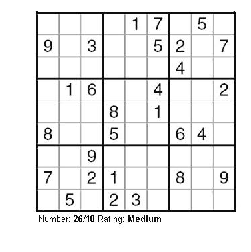

Result:
[[ 0.  0.  0.  0.  1.  7.  0.  5.  0.]
 [ 9.  0.  3.  0.  0.  5.  2.  0.  7.]
 [ 0.  0.  0.  0.  0.  0.  4.  0.  0.]
 [ 0.  1.  6.  0.  0.  4.  0.  0.  2.]
 [ 0.  0.  0.  8.  0.  1.  0.  0.  0.]
 [ 8.  0.  0.  5.  0.  0.  6.  4.  0.]
 [ 0.  0.  9.  0.  0.  0.  0.  0.  0.]
 [ 7.  0.  2.  1.  0.  0.  8.  0.  9.]
 [ 0.  5.  0.  2.  3.  0.  0.  0.  0.]]


In [14]:
imname = 'sudoku_images/sudokus/sudoku18.JPG'
vername = 'sudoku_images/sudokus/sudoku18.sud'
im = array(Image.open(imname).convert('L'))

x = find_sudoku_edges(im, axis=0)
y = find_sudoku_edges(im, axis=1)

crops = []
for col in range(9):
    for row in range(9):
        crop = im[y[col]:y[col+1], x[row]:x[row+1]]
        crops.append(compute_feature(crop))

res = svm_predict(loadtxt(vername), map(list, crops), m)[0]
res_im = array(res).reshape(9, 9)

figure()
gray()
imshow(im)
axis('off')
show()

print 'Result:'
print res_im

In [15]:
from scipy import ndimage
import homography

In [16]:
imname = 'sudoku_images/sudokus/sudoku8.JPG'
im = array(Image.open(imname).convert('L'))

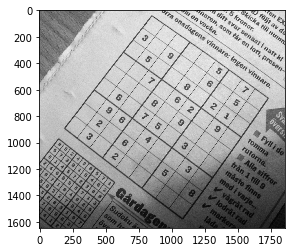

In [17]:
figure()
imshow(im)
gray()
show()

In [18]:
x = [[850, 48], [1726, 662], [1081, 1579], [191, 889]]

In [19]:
fp = array([array([p[1], p[0], 1]) for p in x]).T
tp = array([[0, 0, 1], [0, 1000, 1], [1000, 1000, 1], [1000, 0, 1]]).T

In [20]:
H = homography.H_from_points(tp, fp)

In [21]:
def warpfcn(x):
    x = array([x[0], x[1], 1])
    xt = dot(H, x)
    xt = xt/xt[2]
    return xt[0], xt[1]

In [22]:
im_g = ndimage.geometric_transform(im, warpfcn, (1000, 1000))

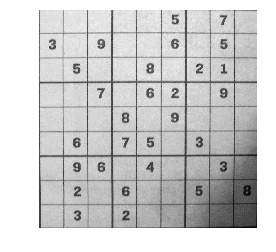

In [23]:
figure()
imshow(im_g)
axis('off')
show()